In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# parser v1
# parse records to list of dicts
# values mostly are strings
# easy to iterate through records
records = []
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        record = {}
        record['timestamp'] = int(components[0])
        record['displayed'] = components[1]
        record['clicked'] = int(components[2])
        # not using user feature
        record['user_features'] = []
        for i in range(4, len(components)):
            if components[i].startswith('|'):
                n = i
                break
            #record['user_features'].append(int(components[i]))
        record['pool'] = components[n:]    
        records.append(record)

In [3]:
len(records)

1607525

In [4]:
# parser that watches article lifespans
lives = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                if component in lives.keys():
                    lives[component][1] = timestamp
                else:
                    lives[component] = [timestamp, timestamp]

In [5]:
lives.keys()

dict_keys(['|id-552077', '|id-555224', '|id-555528', '|id-559744', '|id-559855', '|id-560290', '|id-560518', '|id-560620', '|id-563115', '|id-563582', '|id-563643', '|id-563787', '|id-563846', '|id-563938', '|id-564335', '|id-564418', '|id-564604', '|id-565364', '|id-565479', '|id-565515', '|id-565533', '|id-565561', '|id-565589', '|id-565648', '|id-565747', '|id-565822', '|id-565930', '|id-566013', '|id-566022', '|id-566092', '|id-560805', '|id-564371', '|id-562265', '|id-565980', '|id-566431', '|id-566439', '|id-559833', '|id-566541', '|id-562374', '|id-566587', '|id-566478', '|id-566573', '|id-566602', '|id-562637', '|id-566631', '|id-566689', '|id-566726', '|id-566825', '|id-566838'])

In [6]:
for v in lives.values():
    print(v)

[1317513291, 1317515399]
[1317513291, 1317588299]
[1317513291, 1317587099]
[1317513291, 1317515699]
[1317513291, 1317587099]
[1317513291, 1317587099]
[1317513291, 1317578399]
[1317513291, 1317521099]
[1317513291, 1317581999]
[1317513291, 1317583799]
[1317513291, 1317599694]
[1317513291, 1317515699]
[1317513291, 1317599694]
[1317513291, 1317519299]
[1317513291, 1317571199]
[1317513291, 1317599694]
[1317513291, 1317520799]
[1317513291, 1317535499]
[1317513291, 1317583499]
[1317513291, 1317587399]
[1317513291, 1317583499]
[1317513291, 1317549899]
[1317513291, 1317577499]
[1317513291, 1317586799]
[1317513291, 1317570299]
[1317513291, 1317599694]
[1317517500, 1317582299]
[1317525000, 1317585899]
[1317527100, 1317594299]
[1317529500, 1317564299]
[1317565500, 1317599694]
[1317568200, 1317599694]
[1317569100, 1317599694]
[1317570600, 1317574799]
[1317572400, 1317599694]
[1317573300, 1317599694]
[1317577200, 1317599694]
[1317577800, 1317599694]
[1317578100, 1317599694]
[1317579300, 1317599694]


In [57]:
# offline simulation for AG_L
def AG_L(n=1000000,k=1, m=25, life_threshold=.3):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global records
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            #print('initialized',displayed,':',X[displayed],'t/i:',t,i)
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        #print('Turn', t, 'X_max:', X_max)
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            n_exploit += 1
            
            '''while records[i]['displayed'] != best[0]:
                i += 1
                if i >= len(records):
                    print('read out all records')
                    break
            rewards += records[i]['clicked']'''
                       
            while i < len(records): # look for target arm
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                if displayed == best[0]:
                    rewards += clicked
                    #print('exploited', displayed, ':', clicked, 'i:', i)
                    break
                i += 1
                
        else: # explore
            n_explore += 1           
            while i < len(records):
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                time = records[i]['timestamp']
                born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
                life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
                young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
                if '|'+displayed in list(zip(*young))[0]:
                    rewards += clicked
                    #print('explored', displayed, ':', clicked, 'i:', i)
                    break
                i += 1

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
        t += 1
        i += 1
        
    print('# exploit:', n_exploit)
    print('# explore:', n_explore)
    print('# records:', i)
    print('max expectation:', X_max)
    
    return rewards

In [58]:
# offline simulation for AG_L
def AG_L2(n=1000000,k=1, m=25, life_threshold=.3,verbose=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global records
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            n_exploit += 1

            while i < len(records): # look for target arm
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                if displayed == best[0]:
                    rewards += clicked
                    break
                i += 1
                
        else: # explore
            n_explore += 1
            while i < len(records):
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                time = records[i]['timestamp']
                born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
                life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
                young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
                if '|'+displayed == np.random.choice(list(zip(*young))[0], size=(1,)):
                    rewards += clicked
                    break
                i += 1

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
        t += 1
        i += 1
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)

    return rewards

In [59]:
AG_L(n=5000)

# exploit: 351
# explore: 4624
# records: 26554
max expectation: 0.06454816285998013


233

In [60]:
AG_L2(n=5000)

# exploit: 418
# explore: 4557
# records: 119412
max expectation: 0.0603448275862069


227

In [61]:
AG_L(n=10000)

# exploit: 690
# explore: 9285
# records: 51276
max expectation: 0.06111757857974389


447

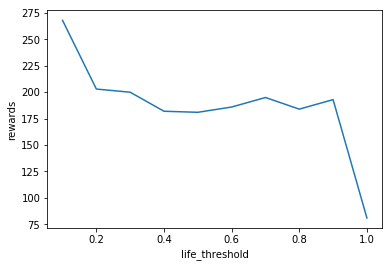

In [53]:
x = []
y = []
for b in np.arange(0.1,1.1,.1):
    x.append(b)
    y.append(AG_L2(n=5000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

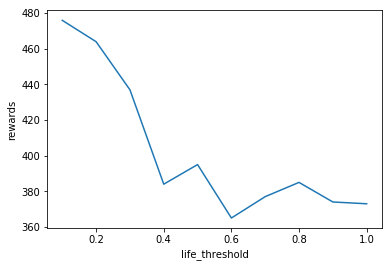

In [30]:
x = []
y = []
for b in np.arange(0.1,1.1,.1):
    x.append(b)
    y.append(AG_L(n=10000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

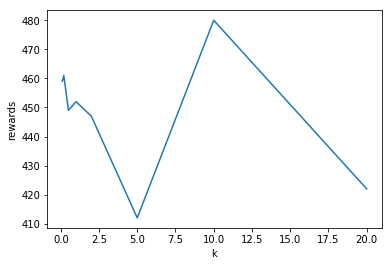

In [39]:
x = []
y = []
for b in [.1,.2,.5,1,2,5,10,20]:
    x.append(b)
    y.append(AG_L(n=10000,k=b, verbose=False))
plt.plot(x,y)
plt.xlabel('k')
plt.ylabel('rewards')
pass

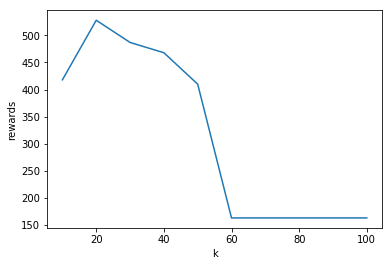

In [43]:
x = []
y = []
for b in [10,20,30,40,50,60,70,80,90,100]:
    x.append(b)
    y.append(AG_L(n=10000,k=b, verbose=False))
plt.plot(x,y)
plt.xlabel('k')
plt.ylabel('rewards')
pass

In [33]:
AG_L(k=50,n=10000)

# exploit: 9974
# explore: 1
# records: 226027
max expectation: 0.04909274193548387


487

In [199]:
AG_L(n=100000)

# exploit: 5584
# explore: 94391
# records: 399813
max expectation: 0.05325370929015576


3836

In [15]:
from collections import Counter

In [16]:
c=Counter()
i=0
while i<100000:
    c[records[i]['clicked']] += 1
    i += 1
c

Counter({0: 96545, 1: 3455})